# Comprendre auto-codeurs de débruitage, et pourquoi les utiliser ?

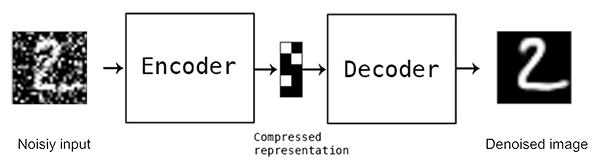

[Source](https://blog.keras.io/building-autoencoders-in-keras.html)

# Importation des packages

In [13]:
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import numpy as np

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import cv2

# Importation des données

In [4]:
# load the MNIST dataset
print("[INFO] loading MNIST dataset...")
((trainX, _), (testX, _)) = mnist.load_data()
# add a channel dimension to every image in the dataset, then scale
# the pixel intensities to the range [0, 1]
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0

[INFO] loading MNIST dataset...
11501568/11490434 [==============================] - 0s 0us/step


In [20]:
print(trainX.shape)
print(testX.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


# Création du bruit

Utilisez la fonction np.random.normal pour générer une matrice de taille trainX.shape selon une loi normal centrer en 0.5 avec un écart type de 0.5 pour chacune des images de notre jeu d'entraînement et de test.

Aidez-vous de la [documentation](https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html).

In [5]:
trainNoise = np.random.normal(loc=0.5, scale=0.5, size=trainX.shape)
testNoise = np.random.normal(loc=0.5, scale=0.5, size=testX.shape)

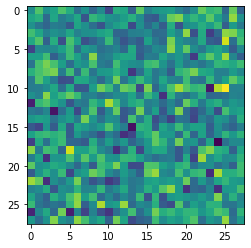

In [9]:
plt.imshow(trainNoise[0, :, :, 0])
plt.show()

Appliquer le bruit sur les images pour créer le dataset d'entraînement et de test. 

Garder les valeurs entre 0 et 1 en utilisant la fonction np.clip.

Aidez-vous de la [documentation](https://numpy.org/doc/stable/reference/generated/numpy.clip.html). 

In [10]:
trainXNoisy = np.clip(trainX + trainNoise, 0, 1)
testXNoisy = np.clip(testX + testNoise, 0, 1)

Regarder la différence entre l'image originale et l'image bruitée. 

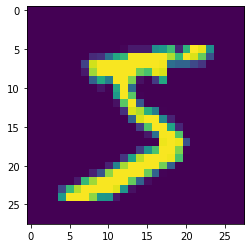

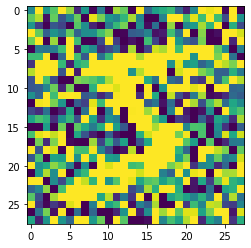

In [11]:
plt.imshow(trainX[0, :, :, 0])
plt.show()
plt.imshow(trainXNoisy[0, :, :, 0])
plt.show()

# Initialisation de l'encodeur

In [35]:
def encoder_model(width, height, depth, latentDim=16):
  inputShape = (height, width, depth)
  chanDim = -1
  inputs = Input(shape=inputShape)
  x = inputs
  x = Conv2D(32, (3, 3), activation='relu')(x)
  x = Conv2D(64, (3, 3), activation='relu')(x)
  x = Flatten()(x)
  latent = Dense(latentDim)(x)

  encoder = Model(inputs, latent, name="encoder")

  return inputs, encoder

In [39]:
inputs, encoder = encoder_model(28, 28, 1, 16)
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_29 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 conv2d_30 (Conv2D)          (None, 24, 24, 64)        18496     
                                                                 
 flatten_8 (Flatten)         (None, 36864)             0         
                                                                 
 dense_13 (Dense)            (None, 16)                589840    
                                                                 
Total params: 608,656
Trainable params: 608,656
Non-trainable params: 0
_________________________________________________________________


# Initialisation du décodeur

In [40]:
def decoder_model(depth, latentDim=16, volume_size=(7, 7, 64)):

  latentInputs = Input(shape=(latentDim,))

  x = Dense(np.prod(volume_size))(latentInputs)
  x = Reshape((volume_size[0], volume_size[1], volume_size[2]))(x)
  x = Conv2DTranspose(64, (3, 3),	activation='relu')(x)
  x = Conv2DTranspose(32, (3, 3),	activation='relu')(x)
  outputs = Conv2D(depth, (3, 3), padding="same", activation='relu')(x)



  decoder = Model(latentInputs, outputs, name="decoder")

  return decoder

In [41]:
decoder = decoder_model(1, 16, (24, 24, 64))
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 16)]              0         
                                                                 
 dense_14 (Dense)            (None, 36864)             626688    
                                                                 
 reshape_5 (Reshape)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_transpose_10 (Conv2D  (None, 26, 26, 64)       36928     
 Transpose)                                                      
                                                                 
 conv2d_transpose_11 (Conv2D  (None, 28, 28, 32)       18464     
 Transpose)                                                      
                                                                 
 conv2d_31 (Conv2D)          (None, 28, 28, 1)         289 

# Initilisation de l'autoenoder 

In [48]:
autoencoder = Model(inputs, decoder(encoder(inputs)), name="autoencoder")

In [49]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 16)                608656    
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         682369    
                                                                 
Total params: 1,291,025
Trainable params: 1,291,025
Non-trainable params: 0
_________________________________________________________________


In [50]:
opt = Adam(lr=1e-3)
autoencoder.compile(loss="mse", optimizer=opt)
# train the convolutional autoencoder
H = autoencoder.fit(
	trainXNoisy, trainX,
	validation_data=(testXNoisy, testX),
	epochs=10,
	batch_size=32)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0106 - val_loss: 0.0184
Epoch 2/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0104 - val_loss: 0.0180
Epoch 3/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0103 - val_loss: 0.0183
Epoch 4/10
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0102 - val_loss: 0.0184
Epoch 5/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0100 - val_loss: 0.0184
Epoch 6/10
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0099 - val_loss: 0.0187
Epoch 7/10
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0098 - val_loss: 0.0188
Epoch 8/10
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0097 - val_loss: 0.0186
Epoch 9/10
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0096 - val_loss: 0.0187
Epoch 10/10
1875/1875 [==============================] - 12s 7ms/step - l

In [53]:
pred = autoencoder(np.expand_dims(testXNoisy[0, :, :, :], axis=0))

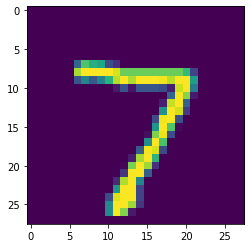

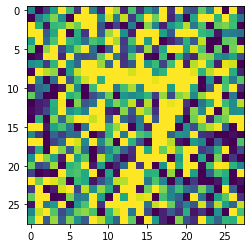

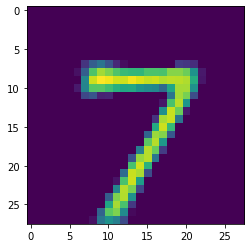

In [54]:
plt.imshow(testX[0, :, :, 0])
plt.show()
plt.imshow(testXNoisy[0, :, :, 0])
plt.show()
plt.imshow(pred[0, :, :, 0])
plt.show()